In [ ]:
import os
import sys
import re
import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import sqlite3

pd.set_option('display.max_columns', None)

ruta_modulo = r"C:\Users\wipip\OneDrive\Documentos\GitHub\Proyecto-Clasificacion-de-Score-Crediticio-main\PROYECTO\src\Exploracion_datos"
sys.path.append(ruta_modulo)
import mis_funciones as mis_funciones
import importlib
importlib.reload(mis_funciones)
from mis_funciones import *


In [25]:
db_path = os.path.join('..', 'data', 'database_credito.db')

try:
    conn = sqlite3.connect(db_path)
    print("Conectado a la base de datos con éxito")
except sqlite3.OperationalError as e:
    print(f"Error al abrir la base de datos: {e}")

Conectado a la base de datos con éxito


In [26]:
data_modelar = pd.read_sql('SELECT * FROM Datos_train_procesados', conn)
conn.close()

In [27]:
data_modelar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69511 entries, 0 to 69510
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Edad                              69511 non-null  int64  
 1   Ingreso_Anual                     69511 non-null  float64
 2   Salario_Mensual_En_Mano           69511 non-null  float64
 3   Numero_Cuentas_Bancarias          69511 non-null  int64  
 4   Numero_Tarjetas_Credito           69511 non-null  int64  
 5   Tasa_Interes                      69511 non-null  int64  
 6   Retraso_Promedio_Pagos            69511 non-null  int64  
 7   Numero_Promedio_Pagos_Retrasados  69511 non-null  float64
 8   Cambio_Limite_Credito             69511 non-null  float64
 9   Numero_Consultas_Credito          69511 non-null  float64
 10  Deuda_Pendiente                   69511 non-null  float64
 11  Ratio_Uso_Credito                 69511 non-null  float64
 12  Anti

Balanceamos la variable objetivo para mejorar la precision en cada categoria 

In [28]:
Counter(data_modelar['Puntaje_Credito'])

Counter({1: 37759, 0: 19878, 2: 11874})

In [29]:
def train_test_data(dataframe, nombre_objetivo, test_size=0.2, random_state=42):
    X = dataframe.drop(nombre_objetivo, axis=1)
    y = dataframe[nombre_objetivo]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test


In [30]:
X_train, X_test, y_train, y_test = train_test_data(data_modelar, 'Puntaje_Credito', 0.2, 42)

Utilizamos un metodo de oversampling, en este caso SMOTE para generar ejemplos sinteticos de las clases minoritarias, ya que desde standard tiene 37K valores comparado con los 11 K valores que tiene Bad, viendo que es casi cuatro veces mas grande una clase que la otra en cuestion de magnitud.

In [31]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"Nueva distribución de las clases: {Counter(y_resampled)}")

Nueva distribución de las clases: Counter({0: 30176, 1: 30176, 2: 30176})


In [32]:
data_modelar_balanceado = pd.concat([X_resampled, y_resampled], axis=1)

In [33]:
conn = sqlite3.connect(db_path)
data_modelar_balanceado.to_sql('Datos_train_proc_bal', conn, if_exists='replace', index=False)

conn.close()

ruta_relativa = '../../data/Processed/'
nombre_archivo = 'Df_mod_blanceado.csv'
ruta_archivo = ruta_relativa + nombre_archivo


data_modelar_balanceado.to_csv(ruta_archivo, index=False)

print(f'Archivo guardado en: {ruta_archivo}')

Archivo guardado en: ../../data/Processed/Df_mod_blanceado.csv


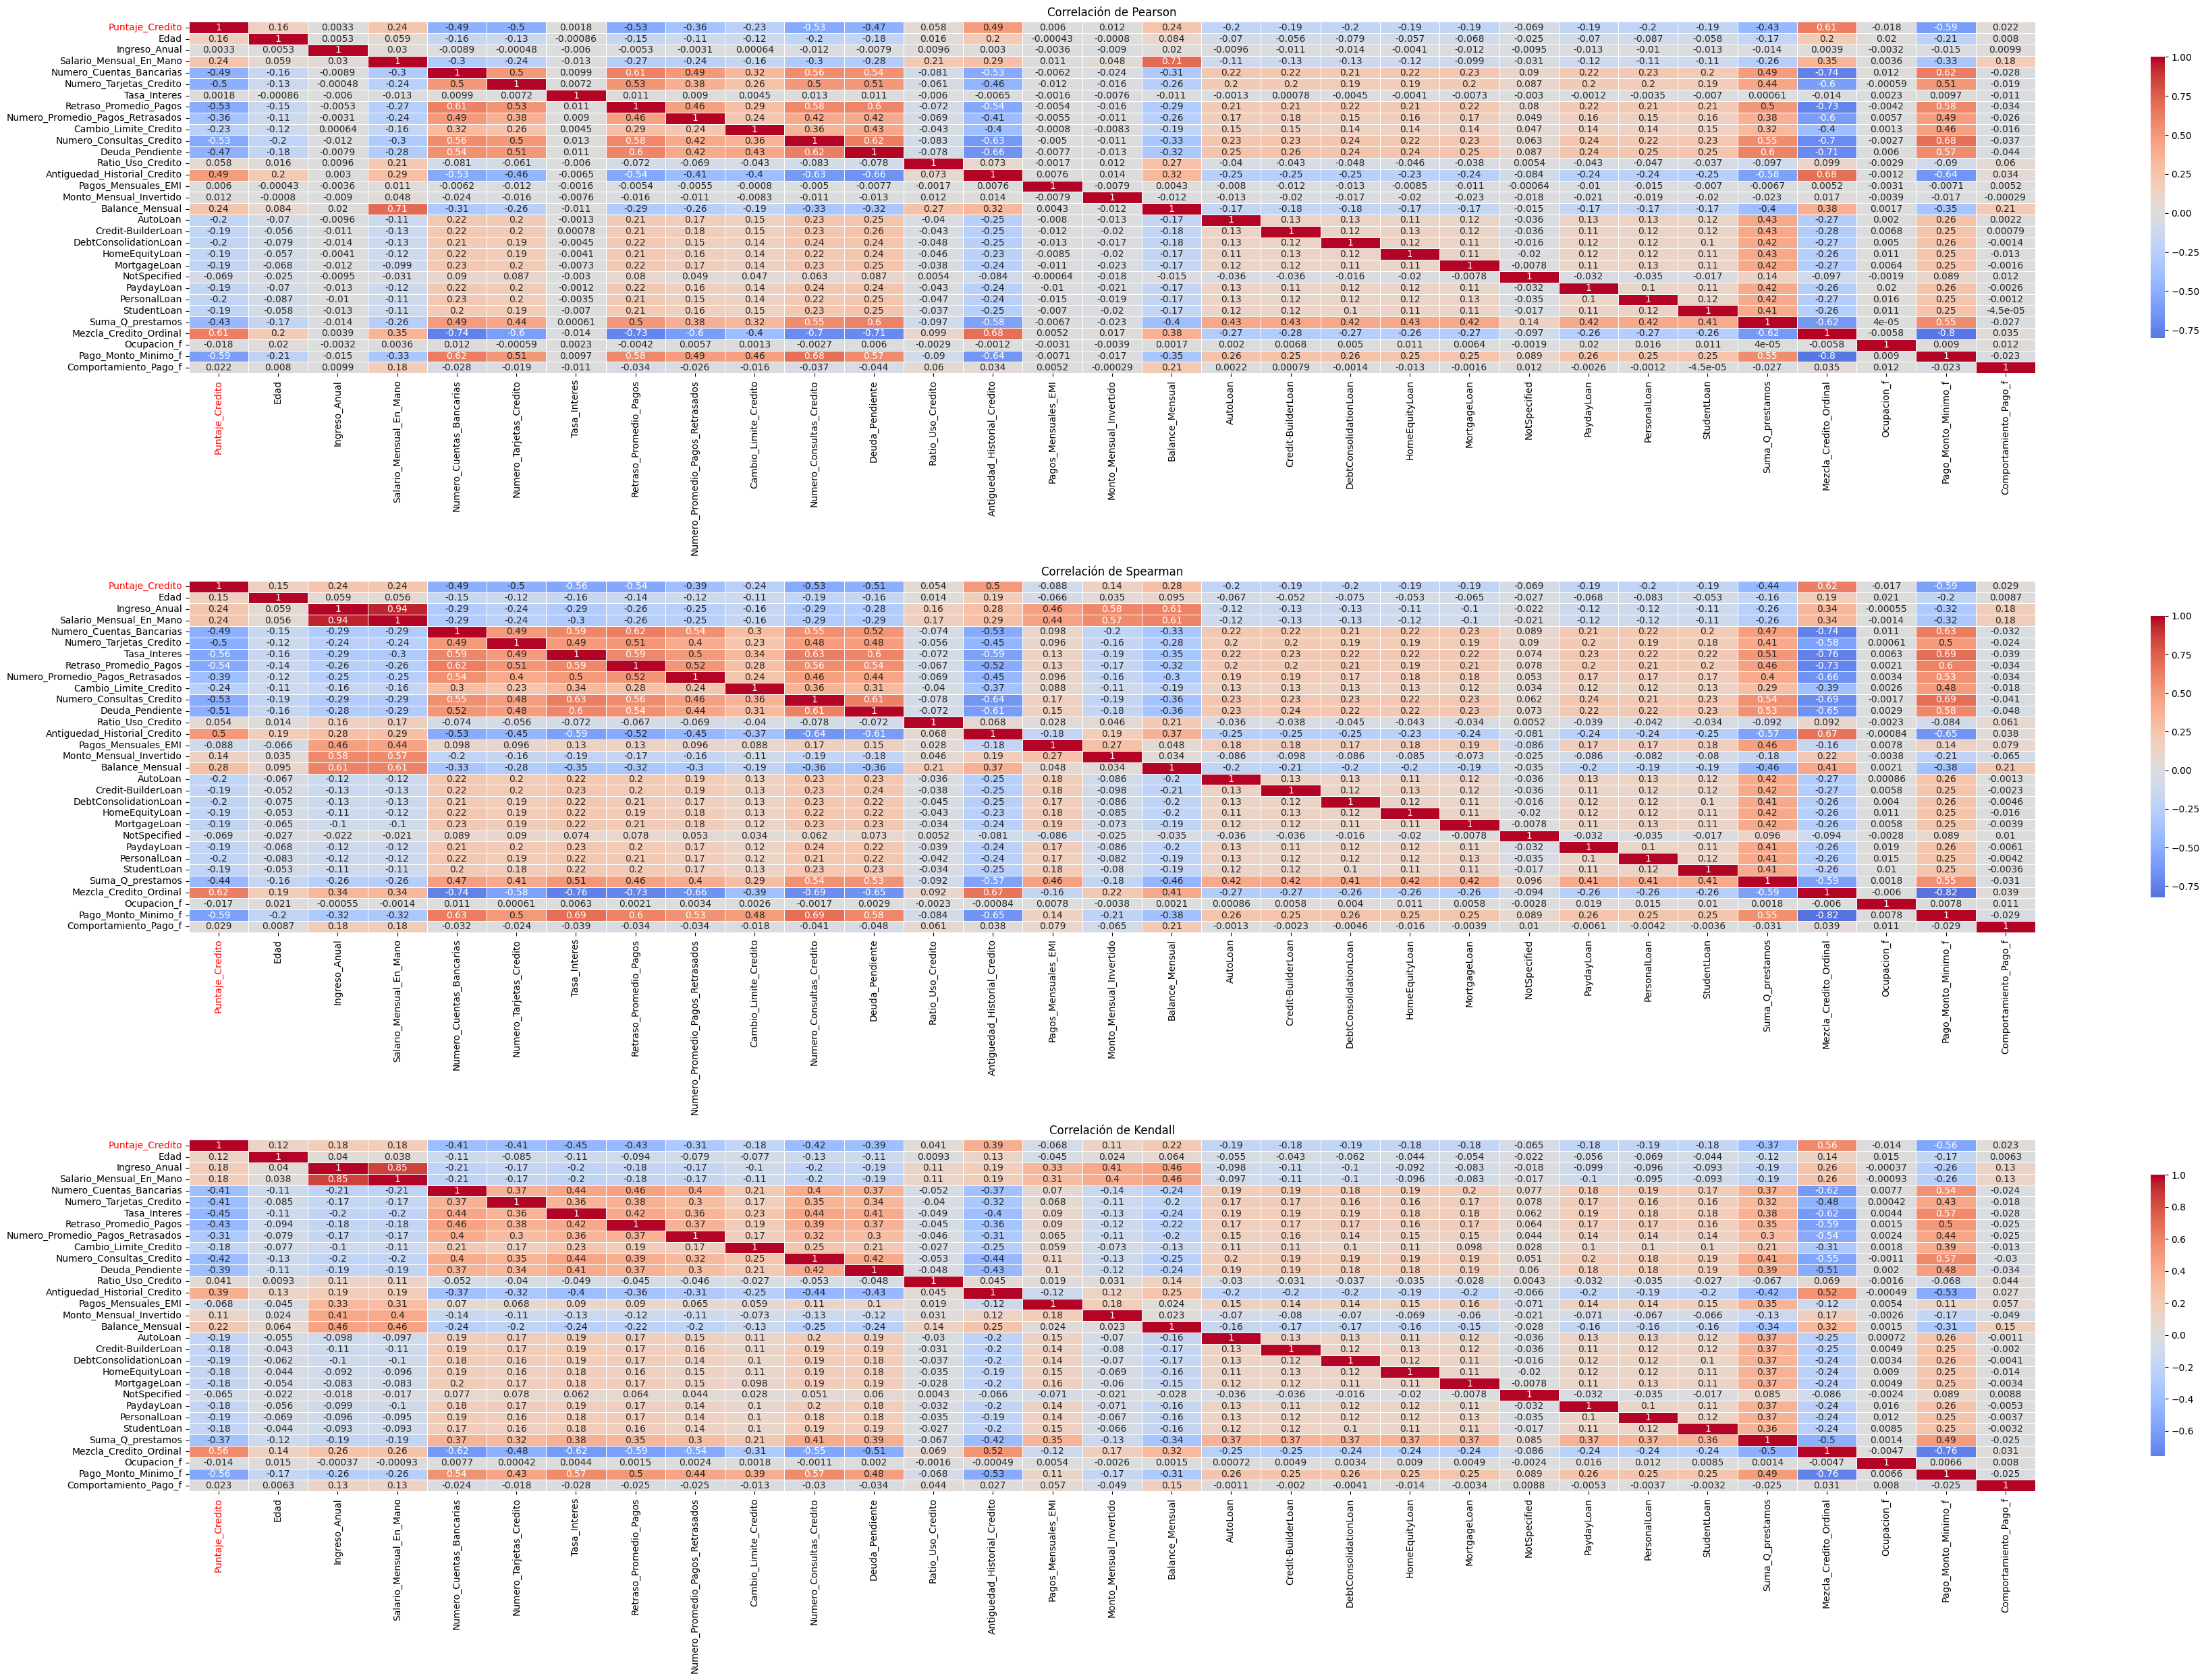

In [34]:
heatmaps_tipo_correlacion(data_modelar_balanceado, 'Puntaje_Credito')

In [35]:
def analizar_correlaciones(data, variable_objetivo):
    corr_pearson = data.corr(method='pearson')
    corr_spearman = data.corr(method='spearman')
    corr_kendall = data.corr(method='kendall')
    
    cols = [variable_objetivo] + [col for col in data.columns if col != variable_objetivo]
    corr_pearson = corr_pearson.loc[cols, cols]
    corr_spearman = corr_spearman.loc[cols, cols]
    corr_kendall = corr_kendall.loc[cols, cols]
    
    corr_pearson_obj = corr_pearson[variable_objetivo].abs().sort_values(ascending=False)
    corr_spearman_obj = corr_spearman[variable_objetivo].abs().sort_values(ascending=False)
    corr_kendall_obj = corr_kendall[variable_objetivo].abs().sort_values(ascending=False)
    
    top_pearson = corr_pearson_obj.iloc[1:11]
    top_spearman = corr_spearman_obj.iloc[1:11]
    top_kendall = corr_kendall_obj.iloc[1:11]
    
    max_corr_pearson = top_pearson.max()
    max_corr_spearman = top_spearman.max()
    max_corr_kendall = top_kendall.max()
    
    avg_corr_pearson = corr_pearson.abs().mean().mean()
    avg_corr_spearman = corr_spearman.abs().mean().mean()
    avg_corr_kendall = corr_kendall.abs().mean().mean()

    resultados = pd.DataFrame({
        'Variable': top_pearson.index,
        'Pearson': top_pearson.values,
        'Spearman': top_spearman.values,
        'Kendall': top_kendall.values
    })
    
    resultados['Max_Correlation'] = resultados[['Pearson', 'Spearman', 'Kendall']].max(axis=1)
    resultados['Avg_Correlation'] = resultados[['Pearson', 'Spearman', 'Kendall']].mean(axis=1)
    
    print("Análisis de correlaciones:")
    print(f"Máxima correlación con la variable objetivo (Pearson): {max_corr_pearson:.4f}")
    print(f"Máxima correlación con la variable objetivo (Spearman): {max_corr_spearman:.4f}")
    print(f"Máxima correlación con la variable objetivo (Kendall): {max_corr_kendall:.4f}")
    
    print(f"\nCorrelación promedio en todo el dataset (Pearson): {avg_corr_pearson:.4f}")
    print(f"Correlación promedio en todo el dataset (Spearman): {avg_corr_spearman:.4f}")
    print(f"Correlación promedio en todo el dataset (Kendall): {avg_corr_kendall:.4f}")

    print("\nInterpretación:")
    if max_corr_pearson > max_corr_spearman and max_corr_pearson > max_corr_kendall:
        print("Las relaciones en el dataset son principalmente lineales.")
    elif max_corr_spearman > max_corr_pearson and max_corr_spearman > max_corr_kendall:
        print("Las relaciones en el dataset son principalmente monótonas pero no necesariamente lineales.")
    else:
        print("Las relaciones en el dataset son monótonas y robustas frente a outliers.")
    
    return resultados




In [36]:

resultados = analizar_correlaciones(data_modelar_balanceado, 'Puntaje_Credito')
print(resultados)

Análisis de correlaciones:
Máxima correlación con la variable objetivo (Pearson): 0.6141
Máxima correlación con la variable objetivo (Spearman): 0.6226
Máxima correlación con la variable objetivo (Kendall): 0.5639

Correlación promedio en todo el dataset (Pearson): 0.1933
Correlación promedio en todo el dataset (Spearman): 0.2423
Correlación promedio en todo el dataset (Kendall): 0.1989

Interpretación:
Las relaciones en el dataset son principalmente monótonas pero no necesariamente lineales.
                           Variable   Pearson  Spearman   Kendall  \
0            Mezcla_Credito_Ordinal  0.614114  0.622600  0.563861   
1               Pago_Monto_Minimo_f  0.592041  0.592041  0.558182   
2          Numero_Consultas_Credito  0.529154  0.555265  0.451609   
3            Retraso_Promedio_Pagos  0.525283  0.544356  0.433829   
4           Numero_Tarjetas_Credito  0.499766  0.525356  0.417852   
5      Antiguedad_Historial_Credito  0.491153  0.507047  0.412110   
6          Numero_C

A continuacion utilizaremos un rango de correlacion para determinar

In [37]:
def reducir_dimensionalidad_correlacion_spearman(data, target_column, threshold=0.3):
    correlaciones = data.corr(method='spearman')[target_column].abs().sort_values(ascending=False)

    selected_features = correlaciones[correlaciones > threshold].index.tolist()

    selected_features = [feature for feature in selected_features if feature != target_column]
    
    data_reducido = data[selected_features + [target_column]]
    
    print(f"Características seleccionadas (correlación de Spearman > {threshold}): {selected_features}")
    return data_reducido, selected_features


In [38]:

data_reducido, selected_features = reducir_dimensionalidad_correlacion_spearman(data_modelar_balanceado, 'Puntaje_Credito', threshold=0.4)
print(f"Dataset reducido:\n{data_reducido.head()}")


Características seleccionadas (correlación de Spearman > 0.4): ['Mezcla_Credito_Ordinal', 'Pago_Monto_Minimo_f', 'Tasa_Interes', 'Retraso_Promedio_Pagos', 'Numero_Consultas_Credito', 'Deuda_Pendiente', 'Antiguedad_Historial_Credito', 'Numero_Tarjetas_Credito', 'Numero_Cuentas_Bancarias', 'Suma_Q_prestamos']
Dataset reducido:
   Mezcla_Credito_Ordinal  Pago_Monto_Minimo_f  Tasa_Interes  \
0                     2.0                    1            25   
1                     2.0                    0            18   
2                     3.0                    0             3   
3                     3.0                    0             1   
4                     3.0                    0          1258   

   Retraso_Promedio_Pagos  Numero_Consultas_Credito  Deuda_Pendiente  \
0                       8                       7.0          1822.87   
1                       9                       3.0          1496.77   
2                       8                       6.0           609.77   


In [42]:
data_reducido.head()

,Mezcla_Credito_Ordinal,Pago_Monto_Minimo_f,Tasa_Interes,Retraso_Promedio_Pagos,Numero_Consultas_Credito,Deuda_Pendiente,Antiguedad_Historial_Credito,Numero_Tarjetas_Credito,Numero_Cuentas_Bancarias,Suma_Q_prestamos,Puntaje_Credito
0,2.0,1,25,8,7.0,1822.87,100.0,6,6,2,0
1,2.0,0,18,9,3.0,1496.77,368.0,7,5,2,1
2,3.0,0,3,8,6.0,609.77,261.0,6,4,4,2
3,3.0,0,1,15,9.0,1343.70,229.0,4,3,1,2
4,3.0,0,1258,3,2.0,153.48,270.0,7,3,1,2


In [49]:
data_reducido.describe()

,Mezcla_Credito_Ordinal,Pago_Monto_Minimo_f,Tasa_Interes,Retraso_Promedio_Pagos,Numero_Consultas_Credito,Deuda_Pendiente,Antiguedad_Historial_Credito,Numero_Tarjetas_Credito,Numero_Cuentas_Bancarias,Suma_Q_prestamos,Puntaje_Credito
count,90528.000000,90528.000000,90528.000000,90528.000000,90528.000000,90528.000000,90528.000000,90528.000000,90528.000000,90528.000000,90528.000000
mean,2.155275,0.503723,69.587796,20.113258,5.574803,1380.274818,227.417808,5.295643,5.216143,2.764460,1.000000
std,0.756131,0.499989,455.113869,14.802650,3.821950,1121.955444,95.617585,2.086685,2.423374,1.551729,0.816501
min,1.000000,0.000000,1.000000,-5.000000,0.000000,0.340000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,7.000000,9.000000,2.437881,554.690000,154.798375,4.000000,3.000000,1.000000,0.000000
50%,2.000000,1.000000,12.000000,16.000000,5.000000,1126.790000,230.000000,5.000000,5.000000,3.000000,1.000000
75%,3.000000,1.000000,20.000000,27.000000,8.000000,1857.470000,304.400000,7.000000,7.000000,4.000000,2.000000
max,3.000000,1.000000,5789.000000,67.000000,17.000000,4998.070000,404.000000,10.000000,10.000000,8.000000,2.000000


In [39]:
def probar_random_forest_default(data1, data2, target_column, test_size=0.2, random_state=42):
    def procesar_dataset(data):
        X = data.drop(columns=[target_column])
        y = data[target_column]
        return train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    X_train1, X_test1, y_train1, y_test1 = procesar_dataset(data1)
    X_train2, X_test2, y_train2, y_test2 = procesar_dataset(data2)

    classifier = RandomForestClassifier(random_state=random_state)

    pipeline = Pipeline([
        ('classifier', classifier)
    ])

    pipeline.fit(X_train1, y_train1)
    y_pred1 = pipeline.predict(X_test1)

    accuracy1 = accuracy_score(y_test1, y_pred1)
    print(f"Accuracy en el primer dataset: {accuracy1:.4f}")
    print("Reporte de clasificación para el primer dataset:")
    print(classification_report(y_test1, y_pred1))

    pipeline.fit(X_train2, y_train2)
    y_pred2 = pipeline.predict(X_test2)

    accuracy2 = accuracy_score(y_test2, y_pred2)
    print(f"\nAccuracy en el segundo dataset: {accuracy2:.4f}")
    print("Reporte de clasificación para el segundo dataset:")
    print(classification_report(y_test2, y_pred2))

    return pipeline


In [40]:

pipeline_model = probar_random_forest_default(data_modelar_balanceado, data_reducido, 'Puntaje_Credito')


Accuracy en el primer dataset: 0.8591
Reporte de clasificación para el primer dataset:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      6110
           1       0.84      0.78      0.81      6020
           2       0.87      0.92      0.90      5976

    accuracy                           0.86     18106
   macro avg       0.86      0.86      0.86     18106
weighted avg       0.86      0.86      0.86     18106


Accuracy en el segundo dataset: 0.8494
Reporte de clasificación para el segundo dataset:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      6110
           1       0.82      0.78      0.80      6020
           2       0.86      0.91      0.89      5976

    accuracy                           0.85     18106
   macro avg       0.85      0.85      0.85     18106
weighted avg       0.85      0.85      0.85     18106



Finalmente se realiza la reduccion de dimensionalidad basandonos en la correlacion que tienen las variables predictoras con nuestra variable objetivo, se decidio hacer esto y conservar el data set reducido debido a que la reduccion en la precision es minima en comparacion con la ventaja que nos da de costo computacional para procesar y optimizar el modelo 

In [41]:
conn = sqlite3.connect(db_path)
data_reducido.to_sql('Data_Red_modelar', conn, if_exists='replace', index=False)

conn.close()
ruta_relativa = '../../data/Processed/'
nombre_archivo = 'Data_Red_modelar.csv'
ruta_archivo = ruta_relativa + nombre_archivo


data_reducido.to_csv(ruta_archivo, index=False)

print(f'Archivo guardado en: {ruta_archivo}')

Archivo guardado en: ../../data/Processed/Data_Red_modelar.csv
